# RESCUE
*Renewable Energy Salient Combined Uncertainty Estimator*

A machine-learning based framework to quantify the short-term uncertainty in netload forecast developed by E3.

Characteristics includes:
1. Weather, time and recent errors aware.
2. Correlation aware as solar,wind, and load errors are co-trained.
3. Produces multiple prediction intervals for expected error in netload forecasting
4. Model agnostic. No requirement on knowledge of the inner workings of the netload forecast

Authors: Yuchi Sun, Vignesh Venugopal, Charles Gulian, Huai Jiang


In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

# 1. Data Ingress

Load in net load forecast error data. Preprocessing of the data is handled by a separate package.

TODO: Standardize the output for stability
TODO: Add in the coverage percentage metric
TODO: Visualization for model performance in different regimes.
TODO: Identify unfinished business.

TODO: Proper CV

TODO: Basic Data check and Assertion

Use `tf.data` to batch and shuffle the dataset:

In [2]:
PI_percentiles = np.array([0.25,0.5,0.75])
model_directory = os.path.join(os.path.dirname(os.getcwd()),'trained_models','rescue_v1_0')

In [3]:
# Read in input and output of the training and validation samples from data pipeline
input_trainval = pd.read_pickle(os.path.join('outputs_from_code','trainval_inputs.pkl')).T
output_trainval = pd.read_pickle(os.path.join('outputs_from_code','trainval_output.pkl')).T

input_train, input_val = input_trainval.iloc[:90000].values.astype('float32'), input_trainval.iloc[90000:].values.astype('float32')
output_train, output_val = output_trainval[:90000].values.astype('float32'), output_trainval[90000:].values.astype('float32')

n_samples = input_trainval.shape[0]
batch_size = 32
max_epochs = 20
optimizer_choice = 'adam'

train_ds = tf.data.Dataset.from_tensor_slices((input_train, output_train)).shuffle(buffer_size= n_samples).batch(batch_size)
val_ds = tf.data.Dataset.from_tensor_slices((input_val, output_val)).shuffle(buffer_size = n_samples).batch(batch_size)

## 2. Model Definition
Define the stucture of the model from start to finish. Includes normalization layer, ANN model and pinball loss.

In [4]:
# class two_layer_ANN(tf.keras.Model):
#     '''
#     A two-layer ANN model with a pinball loss to produce prediction interval.
#     The model can take an arbitrary amounts of input. As a rule of thumb less than 100 input terms would be preferred.
#     The model's target/label should be the true value of the prediction whose upper/lower bound we are interested in. 
#     In our application, since we are interested in the range of forecast erros, the label should be the forecast error.
    
#     '''
#     def __init__(self):
#         super(two_layer_ANN, self).__init__()
#         self.d1 = tf.keras.layers.Dense(10, activation='relu')
#         self.d2 = tf.keras.layers.Dense(10, activation='relu')
#         self.d3 = tf.keras.layers.Dense(1)

#     def call(self, x):
#         x = self.d1(x)
#         x = self.d2(x)
#         x = self.d3(x)
#         return x

Build the ANN model with Pinball loss using the Keras [functional API](https://www.tensorflow.org/guide/keras#model_subclassing)
                                                                    

In [5]:
# Create a model that include the normalization layer
inputs = tf.keras.Input(shape=input_train.shape[1:])

# Create a Normalization layer and set its internal state using the training data
normalizer = tf.keras.layers.experimental.preprocessing.Normalization()
norm_inputs = normalizer(inputs)

# A two-layer ANN network for regression
dense1 = tf.keras.layers.Dense(10, activation='relu')
hidden1 = dense1(norm_inputs)
dense2 = tf.keras.layers.Dense(10, activation='relu')
hidden2 = dense2(hidden1)
dense3 = tf.keras.layers.Dense(1)
outputs = dense3(hidden2)

# define model from inputs to outputs
rescue_model = tf.keras.Model(inputs, outputs)

In [56]:
class PinballLoss(tf.keras.losses.Loss):
    def __init__(self, tau=0.5, name="pinball_loss"):
        super().__init__(name=name)
        self.tau = tau

    def call(self, y_true, y_pred):
        err = y_true - y_pred
        skewed_mse = tf.math.reduce_mean(tf.math.maximum(self.tau * err, (self.tau - 1) * err), axis=0)

        return skewed_mse


class CoverageProbability(tf.keras.metrics.Metric):
    def __init__(self, name = 'CP',**kwargs):
        super(CoverageProbability, self).__init__(name = name, **kwargs)
        self.coverage_probability = self.add_weight(name = 'CP_Var', initializer="zeros", dtype = tf.float64)
        self.cum_n_samples = self.add_weight(name = 'n_samples', initializer="zeros", dtype = tf.int32)
        self.cum_n_covered = self.add_weight(name = 'n_covered', initializer="zeros", dtype = tf.int32)
        
    
    def update_state(self, y_true, y_pred, sample_weight=None):
        # the state would be updated everytime we have a new calculation
        self.cum_n_samples.assign_add(tf.size(y_pred, out_type=tf.int32))
        self.cum_n_covered.assign_add(tf.math.count_nonzero(tf.math.less_equal(y_true,y_pred), dtype = tf.int32))
        self.coverage_probability.assign(tf.math.divide(self.cum_n_covered, self.cum_n_samples))

    def result(self):
        return self.coverage_probability

    def reset_states(self):
        # The state of the metric will be reset at the start of each epoch.
        self.coverage_probability.assign(0.0)
    

# early stopping criteria is validation loss. 
# Min loss change of 1 in 2 epochs (patience)
cb_early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=1, patience=2 , verbose=1)

# we will overwrite the current checkpoint if and only if the `val_loss` score has improved.
# The saved model name will include the current epoch. and into the model_directory folder
def get_cb_check_points_for_tau(model_directory, tau):
    # make sure models for different tau go to different directories
    ckpt_directory = os.path.join(model_directory, "tau={:.0%}".format(tau))
    if not os.path.exists(ckpt_directory):
        os.makedirs(ckpt_directory)
    cb_check_points = tf.keras.callbacks.ModelCheckpoint(filepath=ckpt_directory, save_best_only=True, monitor="val_loss", verbose=0)
    return cb_check_points




In [57]:
# rescue_model_set = {}

# for tau in PI_percentiles:
#     print("Training model for Prediction interval: {:.0%}".format(tau))
    
#     rescue_model_set[tau] = tf.keras.models.clone_model(rescue_model)
#     rescue_model_set[tau].get_layer(index = 1).adapt(input_trainval.values) 
#     rescue_model_set[tau].compile(loss = PinballLoss(tau = tau), metrics= [CoverageProbability()],
#                                   optimizer=optimizer_choice)
#     history = rescue_model_set[tau].fit(train_ds, validation_data=val_ds, epochs=max_epochs, 
#                                         callbacks=[cb_early_stopping, get_cb_check_points_for_tau(model_directory, tau)])

In [58]:
tau = 0.25
print("Training model for Prediction interval: {:.0%}".format(tau))

rescue_model_set[tau] = tf.keras.models.clone_model(rescue_model)
rescue_model_set[tau].get_layer(index = 1).adapt(input_trainval.values) 
rescue_model_set[tau].compile(loss = PinballLoss(tau = tau), metrics= [CoverageProbability()],
                              optimizer=optimizer_choice)
history = rescue_model_set[tau].fit(train_ds, validation_data=val_ds, epochs=3, 
                                    callbacks=[cb_early_stopping, get_cb_check_points_for_tau(model_directory, tau)])

Training model for Prediction interval: 25%
Train for 2813 steps, validate for 350 steps
Epoch 1/3
2813/2813 [==============================] - 4s 1ms/step - loss: 148.0406 - CP: 0.2111 - val_loss: 134.0891 - val_CP: 0.2023
Epoch 2/3
2813/2813 [==============================] - 3s 1ms/step - loss: 101.5375 - CP: 0.2227 - val_loss: 123.1374 - val_CP: 0.2192
Epoch 3/3
2813/2813 [==============================] - 4s 1ms/step - loss: 96.8605 - CP: 0.2279 - val_loss: 117.7206 - val_CP: 0.2255


# 3. Deploying the model

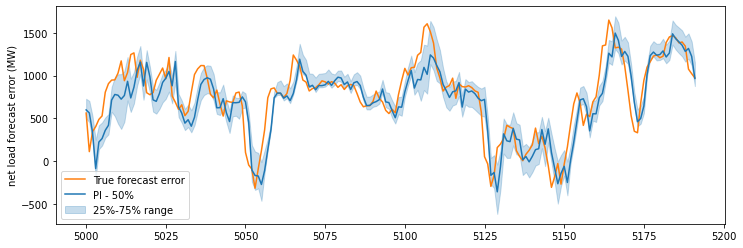

In [8]:
example_range = np.arange(5000,5192)
input_val_eg = input_val[example_range]
output_val_eg = output_val[example_range]

# confirm the PI percentiles are symmetrical
for PI in PI_percentiles:
    assert 1-PI in PI_percentiles, "Not all PI intervals are constructed symmetrically!"


fig,ax = plt.subplots()
ax.plot(example_range, output_val_eg, color = 'C1', label = 'True forecast error')

# plot median forecast if it is being produced
if 0.5 in PI_percentiles:
    ax.plot(example_range, rescue_model_set[0.5].predict(input_val_eg), color = 'C0', label = 'PI - 50%')

for PI in PI_percentiles:
    if PI<0.5:
        ax.fill_between(example_range, np.squeeze(rescue_model_set[PI].predict(input_val_eg)),
                        np.squeeze(rescue_model_set[1-PI].predict(input_val_eg)),
                        color = 'C0', alpha = PI, label = '{:.0%}-{:.0%} range'.format(PI, 1-PI))

ax.set_ylabel("net load forecast error (MW)")
ax.legend()
fig.set_size_inches(12,4)

plt.show()

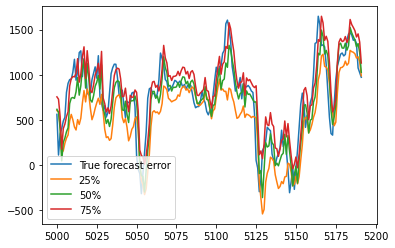

In [52]:
example_range = np.arange(5000,5192)
input_val_eg = input_val[example_range]
output_val_eg = output_val[example_range]

# confirm the PI percentiles are symmetrical
for PI in PI_percentiles:
    assert 1-PI in PI_percentiles, "Not all PI intervals are constructed symmetrically!"


fig,ax = plt.subplots()
ax.plot(example_range, output_val_eg, label = 'True forecast error')
ax.plot(example_range, rescue_model_set[0.25].predict(input_val_eg), label = '25%')
ax.plot(example_range, rescue_model_set[0.5].predict(input_val_eg), label = '50%')
ax.plot(example_range, rescue_model_set[0.75].predict(input_val_eg), label = '75%')
ax.legend()

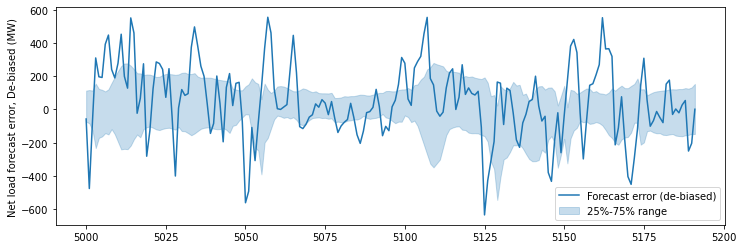

In [10]:
fig,ax = plt.subplots()
inherent_bias_eg = np.squeeze(rescue_model_set[0.5].predict(input_val[example_range]))

ax.plot(example_range, np.squeeze(output_val_eg) - inherent_bias_eg, label = 'Forecast error (de-biased)')

for PI in PI_percentiles:
    if PI<0.5:
        ax.fill_between(example_range, np.squeeze(rescue_model_set[PI].predict(input_val_eg)) - inherent_bias_eg,
                        np.squeeze(rescue_model_set[1-PI].predict(input_val_eg)) - inherent_bias_eg,
                        color = 'C0', alpha =PI, label = '{:.0%}-{:.0%} range'.format(PI, 1-PI))


ax.set_ylabel("Net load forecast error, De-biased (MW)")
ax.legend()
fig.set_size_inches(12,4)

plt.show()

Choose an optimizer and loss function for training: 

Select metrics to measure the loss and the accuracy of the model. These metrics accumulate the values over epochs and then print the overall result.

In [7]:
# train_loss = tf.keras.metrics.Mean(name='train_loss')
# test_loss = tf.keras.metrics.Mean(name='test_loss')

Use `tf.GradientTape` to train the model:

Test the model:

In [9]:
@tf.function
def train_step(inputs, outputs, model, loss_fn):
    with tf.GradientTape() as tape:
        # training=True is only needed if there are layers with different
        # behavior during training versus inference (e.g. Dropout).
        predictions = model(inputs, training=True)
        loss = loss_fn(outputs, predictions)
    gradients = tape.gradient(loss, rescue.trainable_variables)
    optimizer.apply_gradients(zip(gradients, rescue.trainable_variables))

    train_loss(loss)
    #train_accuracy(outputs, predictions)


@tf.function
def test_step(inputs, outputs, model, loss_fn):
    # training=False is only needed if there are layers with different
    # behavior during training versus inference (e.g. Dropout).
    predictions = rescue(inputs, training=False)
    t_loss = loss_object(outputs, predictions)

    test_loss(t_loss)
    #test_accuracy(outputs, predictions)

In [10]:
# EPOCHS = 5

# for epoch in range(EPOCHS):
#   # Reset the metrics at the start of the next epoch
#   train_loss.reset_states()
#   #train_accuracy.reset_states()
#   test_loss.reset_states()
#   #test_accuracy.reset_states()

#   for inputs, outputs in train_ds:
#     train_step(inputs, outputs)

#   for test_inputs, test_outputs in test_ds:
#     test_step(test_inputs, test_outputs)

#   print(
#     f'Epoch {epoch + 1}, '
#     f'Loss: {train_loss.result()}, '
#     #f'Accuracy: {train_accuracy.result() * 100}, '
#     f'Test Loss: {test_loss.result()}, '
#     #f'Test Accuracy: {test_accuracy.result() * 100}'
#   )

Epoch 1, Loss: nan, Test Loss: nan, 
Epoch 2, Loss: nan, Test Loss: nan, 
Epoch 3, Loss: nan, Test Loss: nan, 
Epoch 4, Loss: nan, Test Loss: nan, 
Epoch 5, Loss: nan, Test Loss: nan, 
